In [35]:
# from core import download_IC
# from core import download_ATNF

In [36]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
from scipy import integrate as scint
# import torch
# from core import weights

In [37]:
num_threads = int(mul.cpu_count()*0.8)
set_num_threads(num_threads)

In [38]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

master_nbins = int(1e6)
# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, master_nbins)

decl_bins=master_nbins//1000
decls = np.linspace(-np.pi/2, np.pi/2, decl_bins)

In [39]:
dec_nu

array([-90.  , -73.74, -66.93, -61.64, -57.14, -53.13, -49.46, -46.05,
       -42.84, -39.79, -36.87, -34.06, -31.33, -28.69, -26.1 , -23.58,
       -21.1 , -18.66, -16.26, -13.89, -11.54,  -9.21,  -6.89,  -4.59,
        -2.29,   0.  ,   2.29,   4.59,   6.89,   9.21,  11.54,  13.89,
        16.26,  18.66,  21.1 ,  23.58,  26.1 ,  28.69,  31.33,  34.06,
        36.87,  39.79,  42.84,  46.05,  49.46,  53.13,  57.14,  61.64,
        66.93,  73.74,  90.  ])

In [40]:
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
    
    
decls_bin_indices = np.zeros(len(decls), dtype=np.int64)

for i in prange(decl_bins):
    decls_bin_indices[i] = np.digitize(decls[i], dec_nu) - 1
    

In [41]:
msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1


In [42]:
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...




In [43]:
eareaa = [i.astype(np.float64) for i in earea]

In [44]:
eareaa = np.asfarray(eareaa, dtype=np.float64)

In [45]:
eareaa[0][0]

0.0

In [46]:
earea2 = np.asfortranarray(earea)

In [47]:
earea2 = earea2[0].astype(np.float64)

In [48]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def eqn10(decl_index, gamma, season):
    tt_upt = t_upt[season]
    l = decls_bin_indices[decl_index]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


    return np.trapz(wt_ac_temp, enus)
    

In [49]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


    return np.trapz(wt_ac_temp, enus)


wt_vec = psr_wt_sing_gamma(range(p), -1, 0)

In [50]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]

In [51]:
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all pulsars and seasons and gamma")

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000


In [52]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)

In [53]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2


In [54]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [55]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)



Loading all_Si_ws_g_s from pickle
Loaded all_Si_ws_g_s from pickle with nbins = 1000000


In [56]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [57]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)

Loading all_Bi from pickle...
Loaded all_Bi from pickle


In [64]:
@njit
def aeff(energy, dec, season):
    '''
    Parameters
    ----------
    energy : float
        Energy of the neutrino in GeV.
    dec : float
        Declination of the neutrino in radians.
    season : int
        Season of the neutrino (0 = Summer, 1 = Winter).
        
    Returns
    -------
    float
        Effective area of the detector in m^2.
    
    '''
    return earea[ea_season(season)][(np.digitize(energy, e_nu_wall) - 1) + (np.digitize(dec, dec_nu) - 1)*40]
# def ns_newhat(e_bin, dec_bin, season=0, gamma=-1):
e_bin = 0
dec_bin = 0
season = 0
gamma = -2
# earea[season][dec_bin*40 + e_bin] * dfde(e_integrand) * e_integrand * np.cos(decl_integrand)

@njit()
def ns_newhat(e_integrand, decl_integrand, e_bin, dec_bin, season=0, gamma=-2):
    return earea[ea_season( season)][dec_bin*40 + e_bin] * dfde(e_integrand, gamma, 1e-20) * e_integrand * np.cos(decl_integrand)

# for season in range(10):
@njit
def scintegrate(ns_newhat, a, b, c, d, e_bin, dec_bin, season, gamma):
    # Manually implement the integration using Numba
    ns_sum = 0.0
    err_sum = 0.0
    num_points = 100  # Number of points for integration

    e_step = (b - a) / num_points
    dec_step = (d - c) / num_points

    for i in range(num_points):
        e_start = a + i * e_step
        e_end = e_start + e_step
        for j in range(num_points):
            dec_start = c + j * dec_step
            dec_end = dec_start + dec_step

            ns_val = ns_newhat((e_start + e_end) / 2, (dec_start + dec_end) / 2, e_bin, dec_bin, season, gamma)
            ns_sum += ns_val

            err_val = np.abs(ns_newhat((e_start + e_end) / 2, (dec_start + dec_end) / 2, e_bin, dec_bin, season, gamma))
            err_sum += err_val

    ns_sum *= e_step * dec_step
    err_sum *= e_step * dec_step

    return ns_sum, err_sum

@njit
def ns_singseason_sing_e(e_bin, season=0, gamma=-2):
    ns_singseason = 0
    err_ns = 0
    # for e_bin in tqdm(range(len(e_nu_wall) - 1)):
    for dec_bin in range(len(dec_nu) - 1):
        temp = scintegrate(ns_newhat, e_nu_wall[e_bin], e_nu_wall[e_bin + 1], dec_nu[dec_bin], dec_nu[dec_bin + 1],e_bin, dec_bin, season, gamma) #args=(e_bin, dec_bin, season, gamma))
        ns_singseason += temp[0]
        err_ns += np.abs(temp[1])
    return np.asfarray([ns_singseason, err_ns])


In [65]:
print(ns_singseason_sing_e(1, 0, -2.2))

[7.49630627e+08 3.89566905e+10]


In [66]:
arr

[array([2.57188426e+42, 2.51436891e+44]),
 array([           nan, 6.90814365e+45]),
 array([           nan, 8.83360416e+49]),
 array([8.63927577e+54, 3.75779314e+56])]

In [67]:
all_ns_HAT = []
for gamma in gamma_arr:
    all_ns_sing_gamma = np.asfarray([0, 0])
    for season_i in tqdm(range(10)):
        @njit
        def ns_singseason(e_bin, season=season_i, gamma=gamma):
            # clear_output(wait=True)
            return ns_singseason_sing_e(e_bin, season, gamma)

        pool = mul.Pool(50)
        op_async = pool.map_async(ns_singseason, range(len(e_nu_wall) - 1))
        pool.close()
        pool.join()
        temp = op_async.get()
        temp = np.multiply(temp, t_upt[season_i])
        all_ns_sing_gamma += np.sum(temp, axis=0)
        op_async = []
        pool = []
    all_ns_HAT.append(all_ns_sing_gamma)



100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


In [68]:
all_ns_HAT

[array([3.59748166e+24, 2.50397784e+26]),
 array([8.28705530e+23, 6.75105715e+25]),
 array([1.13093927e+23, 1.46113443e+25]),
 array([6.28652747e+22, 9.31586733e+24])]

with open(altier_path[0] + f'all_ns_HAT_spl.pkl', 'wb') as f:
        pickle.dump(all_ns_HAT, f)

In [27]:
if os.path.isfile(altier_path[0] + f'all_ns_HAT_spl.pkl'):
    print("Loading all_ns_HAT_spl from pickle...")
    with open(altier_path[0] + f'all_ns_HAT_spl.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded all_ns_HAT_spl from pickle")
else:
    print("\nCalculating ns_HAT spl\n")
    all_ns_HAT = []
    for gamma in gamma_arr:
        all_ns_sing_gamma = np.asfarray([0, 0])
        for season_i in tqdm(range(10)):
            def ns_singseason(e_bin, season=season_i, gamma=gamma):
                # clear_output(wait=True)
                return ns_singseason_sing_e(e_bin, season, gamma)

            pool = mul.Pool(50)
            op_async = pool.map_async(ns_singseason, range(len(e_nu_wall) - 1))
            pool.close()
            pool.join()
            temp = op_async.get()
            temp = np.multiply(temp, t_upt[season_i])
            all_ns_sing_gamma += np.sum(temp, axis=0)
            op_async = []
            pool = []
        all_ns_HAT.append(all_ns_sing_gamma)
    # all_Bi+=1e-90
    print("\nCalculated ns_HAT spl")
    #Save to pickle
    with open(altier_path[0] + f'all_ns_HAT_spl.pkl', 'wb') as f:
        pickle.dump(all_ns_HAT, f)
    
    arr = all_ns_HAT

  0%|          | 0/10 [00:00<?, ?it/s]


Calculating ns_HAT spl



/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges. 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

 50%|█████     | 5/10 [06:57<07:07, 85.49s/it]/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integ

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 


/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges. 

/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/home/physics-3/.local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

In [27]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

t2mp = all_Si_ws_g_s[0][0]
nsa = 50
@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 

TS_for_all_psrs2(nsa)

In [28]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)

In [29]:
arr

[array([2.57188426e+22, 2.51436892e+24]),
 array([           nan, 6.90814365e+25]),
 array([           nan, 8.83360416e+29]),
 array([8.63927576e+34, 3.75779314e+36])]

In [30]:
phio = np.logspace(-38, -28, 1000)/1e-20

In [48]:
print('\nCALCULATING TS FOR ALL NS SPL FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(4):
    tmpp = []
        print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][0]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL NS SPL FOR ALL GAMMAS FOR ALL WEIGHTS')

  0%|          | 0/1000 [00:00<?, ?it/s]


CALCULATING TS FOR ALL NS SPL FOR ALL GAMMAS FOR ALL WEIGHTS

gamma = 0


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 1


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 2


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 3


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 0


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 1


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 2


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 3


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 0


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 1


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 2


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 3


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 0


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 1


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 2


  0%|          | 0/1000 [00:00<?, ?it/s]

gamma = 3


100%|██████████| 1000/1000 [00:09<00:00, 107.25it/s]


CALCULATED TS FOR ALL NS SPL FOR ALL GAMMAS FOR ALL WEIGHTS


### $N \approx 10^6$

In [49]:
all_TSS = np.array(all_TSS, dtype=np.float64)
all_TSS.shape

(4, 4, 1000)

/home/physics-3/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/physics-3/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


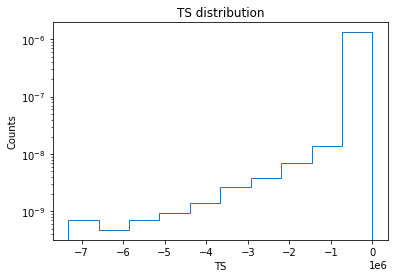

In [50]:
# for i in range(1, len(all_TSS)):
plt.figure()
histdetails = plt.hist(np.ravel(all_TSS[1:]), bins=10, density=True, histtype='step')
# plt.ylim(0, 1000)
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('Counts')
plt.title('TS distribution')
plt.show()

In [51]:
histdetails = np.histogram(np.ravel(all_TSS[1:]), bins=10)

ValueError: autodetected range of [nan, nan] is not finite

In [52]:
histdetails

(array([7.14258030e-10, 4.76172020e-10, 7.14258030e-10, 9.52344040e-10,
        1.42851606e-09, 2.61894611e-09, 3.80937616e-09, 6.90449429e-09,
        1.40470746e-08, 1.33328166e-06]),
 array([-7.32627529e+06, -6.59364617e+06, -5.86101704e+06, -5.12838791e+06,
        -4.39575878e+06, -3.66312966e+06, -2.93050053e+06, -2.19787140e+06,
        -1.46524227e+06, -7.32613145e+05,  1.59826940e+01]),
 <a list of 1 Patch objects>)

In [53]:
len(np.ravel(all_TSS[1:]))

12000

In [54]:
np.count_nonzero(np.ravel(all_TSS[1:])> 5)

/home/physics-3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


165

In [55]:
11841/12000

0.98675

In [56]:
all_TSS = np.array(all_TSS, dtype=np.float64)

In [57]:
all_TSS.shape

(4, 4, 1000)

In [59]:
for w in range(4):
    for g in range(len(gamma_arr)):
        print(gamma_arr[g])
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
    # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        

with open(altier_path[0] + f'all_TSS_spl.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)

-2.0
1.1191048088221577e-13 0.01222809774517676
-2.2
nan nan
-2.53
nan nan
-3.0
-1200796.9106762938 3007984.732361505
-2.0
-2.592792647249098e-10 1.3859046913645434e-07
-2.2
nan nan
-2.53
nan nan
-3.0
-7124341.28518762 15.982693983884149
-2.0
-2.600546444853084e-10 9.6553321442505e-08
-2.2
nan nan
-2.53
nan nan
-3.0
-7275688.391060943 4.902195205801444
-2.0
-2.569779944394677e-10 1.8540277970782295e-07
-2.2
nan nan
-2.53
nan nan
-3.0
-7326275.293734601 7.272144859511725


In [44]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']

In [45]:
all_TSS[1].shape

(4, 1000)

In [46]:
#Gamma = -2.5
#ws = 1/dist**2
e2dfde = all_e_UL[1][2]
dist_g25 = interp.interp1d(all_TSS[1][2], e2dfde/1e9)

print(dist_g25(-3.84))

all_UL = []
for ws in range(1,4):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)

nan


ValueError: A value in x_new is below the interpolation range.

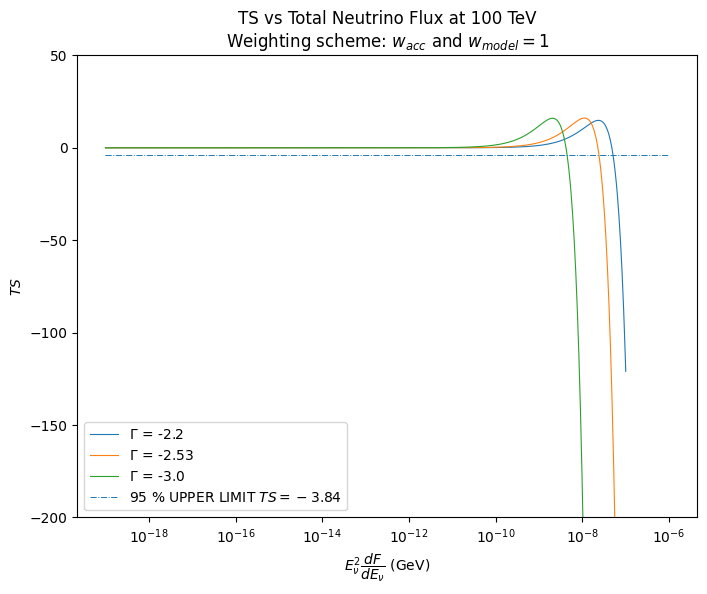

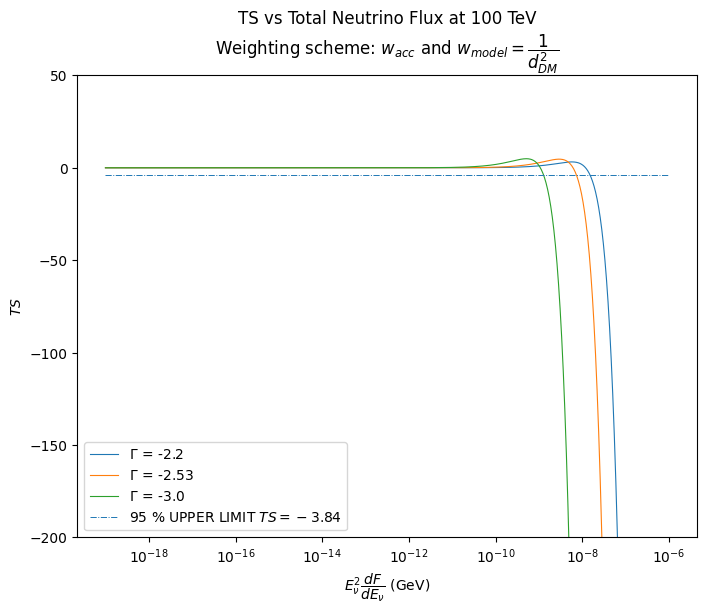

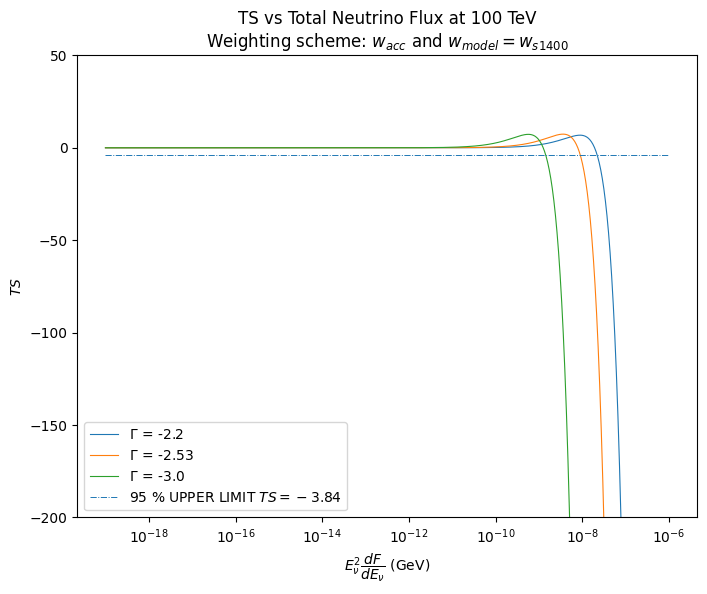

In [46]:
e2dfde = all_e_UL[1]


        # print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))
# for i in range(1, 4):
plt.figure(figsize=(8, 6))
for j in range(1, len(gamma_arr)):
    plt.plot(e2dfde[j]/1e9, all_TSS[j], label='$\Gamma$ = ' + str(gamma_arr[j]), lw=0.8)
        # ci = st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j]))
        # plt.hlines(ci, 1e-19, 1e-6, colors='k', linestyles='dashed', lw=0.5, ls='-.', label="95% CI "+ '$\Gamma$ = ' + str(gamma_arr[j]))

    plt.hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
    # plt.vlines(dist_g25(-3.84), -120, 50, linestyles='dashed', lw=0.5, ls='-.')
    plt.legend()
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
    plt.ylabel(r'$TS$')
    plt.ylim(-200, 50)
    plt.title("TS vs Total Neutrino Flux at 100 TeV\nWeighting scheme: " + plttitles[i-1])
    plt.savefig(os.getcwd() + f'/outputs/TSvsE2dFdE_ws_{i}.png', facecolor='w')
    plt.show()

for i in range(1,4):
    for j in range(4):
        print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))

all_UL = []
enus2 = np.logspace(11.001, 18.999, 100)
for j in prange(4):
    upp_lim = []
    for i in enus2:
        e2dfde2 = i**2 * dfde(i, gamma_arr[j], 1) * phio
        upp_lim.append(st.t.interval(0.95, len(e2dfde2)-1, loc=np.mean(e2dfde2), scale=st.sem(e2dfde[j]))[1])
    all_UL.append(upp_lim)

all_UL = np.asarray(all_UL)

for i in range(1,4):
    plt.plot(enus2/1e9, all_UL[i]/1e9, label='$\Gamma$ = ' + str(gamma_arr[i]))

plt.xlabel('$E_{\u03BD}$ (GeV)')
plt.ylabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3, 1e7)


np.digitize(4.480886277446552, e2dfde[1])

In [77]:
def dfde_ul(enu, gamma, phi, flux=1e14):
    return phi * (enu/flux)**gamma


TS_vs_E2dfde_all_w_model_bins=1000000.png
DONE


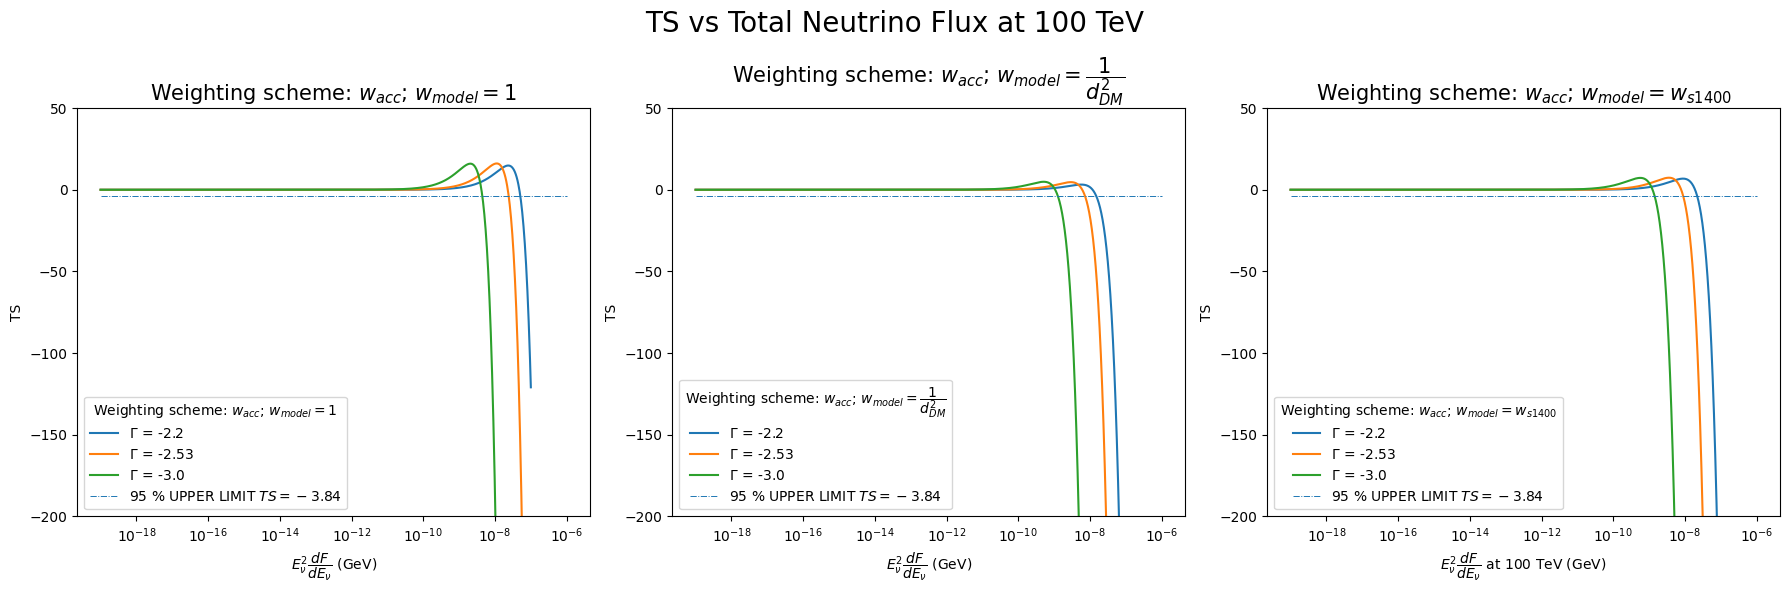

In [112]:
plt.style.use('default')
fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in [ 1, 2, 3]:#range(4):
    # axs[0,0].plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))    #in GeV

    axs[0].plot(e2dfde[gamma]/1e9, all_TSS[1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1].plot(e2dfde[gamma]/1e9, all_TSS[2][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[2].plot(e2dfde[gamma]/1e9, all_TSS[3][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

axs[0].set_title('Weighting scheme: $w_{acc}$; $w_{model} = 1$', fontsize=15)
axs[1].set_title('Weighting scheme: $w_{acc}$; $w_{model} = \dfrac{1}{d_{DM}^2}$' , fontsize=15)
axs[2].set_title('Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$', fontsize=15)




axs[0].hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
axs[1].hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
axs[2].hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')

axs[0].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = 1$')
axs[0].set_xscale('log')
axs[0].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[0].set_ylabel('TS')
# axs[0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0].set_ylim(-200, 50)

axs[1].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} =\dfrac{1}{d_{DM}^2}$')
axs[1].set_xscale('log')
axs[1].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)')
axs[1].set_ylabel('TS')
# axs[1].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[1].set_ylim(-200, 50)

axs[2].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$')
axs[2].set_xscale('log')
axs[2].set_xlabel('$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ at 100 TeV (GeV)')
axs[2].set_ylabel('TS')
# axs[2].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[2].set_ylim(-200, 50)


plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontsize=20)
plt.tight_layout()
plt.savefig(f'TS_vs_E2dfde_all_w_model_bins={len(enus)}.png')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')

In [ ]:
plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']
# plt.plot(e_decade, temp, 'o-')
for ws in range(3):
    plt.figure(figsize=(8, 6))
    for gamma in range(1, len(gamma_arr)):
        plt.plot(np.divide(e_decade, 1e9), all_UL[ws][gamma], label=f'$\Gamma$ = {gamma_arr[gamma]}')

    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('E$_{\u03BD}$ (GeV)')
    plt.ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
    plt.title("95% UL of Total Energy Flux vs Neutrino Energy\nWeighting scheme: " + plttitles[ws])
    plt.savefig(f'outputs/UL_{ws}.png', facecolor='white')

In [95]:
np.shape(all_UL)

(3, 4, 5)

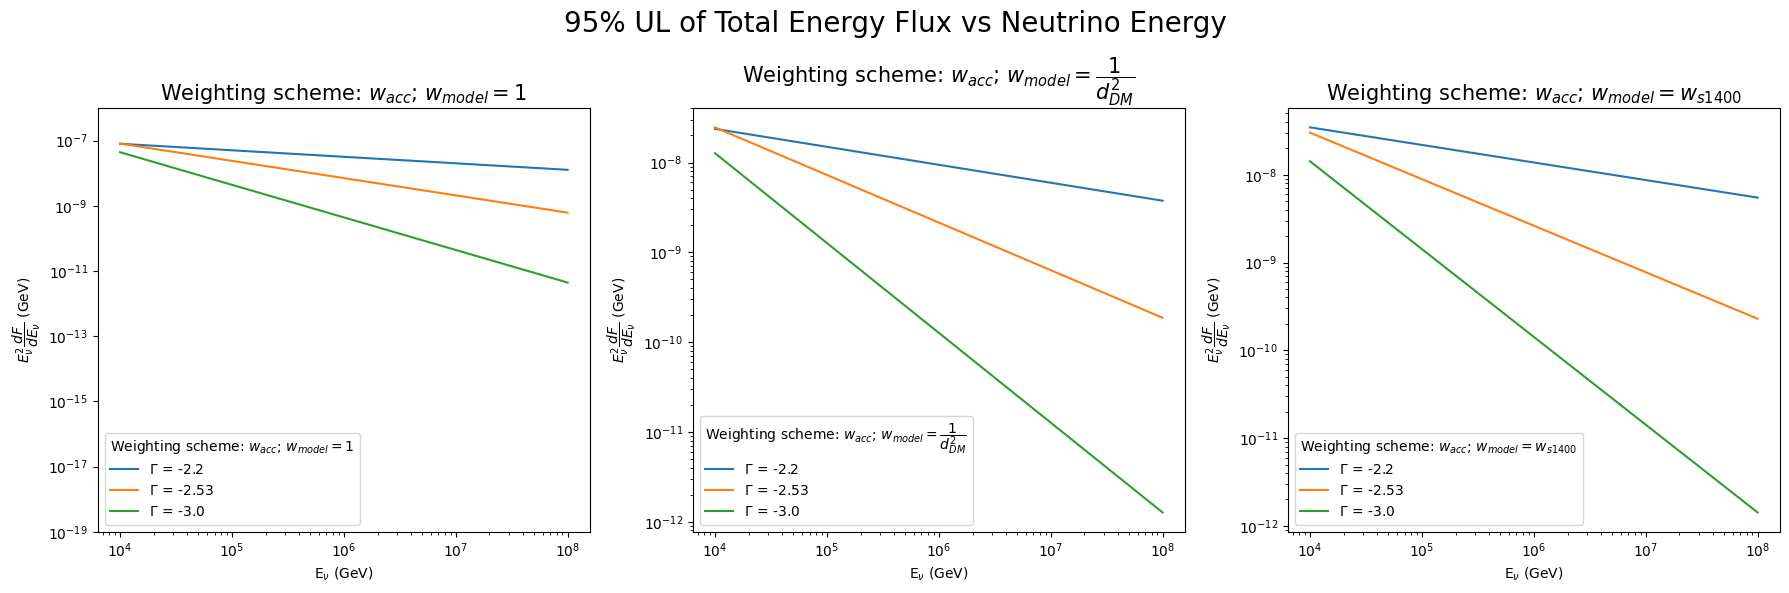

In [111]:
#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))

for gamma in range(1, len(gamma_arr)):

    axs[0].plot(np.divide(e_decade, 1e9), all_UL[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt')    #in GeV

    axs[1].plot(np.divide(e_decade, 1e9), all_UL[1][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and dist')    #in GeV

    axs[2].plot(np.divide(e_decade, 1e9), all_UL[2][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]))# + ' with wt and s1400')    #in GeV

axs[0].set_title('Weighting scheme: $w_{acc}$; $w_{model} = 1$', fontsize=15)
axs[1].set_title('Weighting scheme: $w_{acc}$; $w_{model} = \dfrac{1}{d_{DM}^2}$' , fontsize=15)
axs[2].set_title('Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$', fontsize=15)

leg = axs[0].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = 1$')
leg._legend_box.align = "left"
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[0].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
# axs[0].set_title('TS vs $E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$')
axs[0].set_ylim(1e-19, 1e-6)

leg = axs[1].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} =\dfrac{1}{d_{DM}^2}$')
leg._legend_box.align = "left"
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[1].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")

leg = axs[2].legend(title = 'Weighting scheme: $w_{acc}$; $w_{model} = w_{s1400}$')
leg._legend_box.align = "left"
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('E$_{\u03BD}$ (GeV)')
axs[2].set_ylabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")

plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontsize=20)
plt.tight_layout()
# plt.savefig(f'outputs/UL_all_w_model_bins={len(enus)}.png')
plt.show()

